In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import retinanet_resnet50_fpn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

In [3]:
DATA_ROOT = "/home/ubuntu/CS230_final_project/CS230-final-project/drone_dataset"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR = os.path.join(DATA_ROOT, "valid")
TEST_DIR = os.path.join(DATA_ROOT, "test")
MODEL_SAVE_DIR = "retina_models"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# test_folder = '/home/ubuntu/CS230_final_project/CS230-final-project/drone_dataset/test'
# output_folder = '/home/ubuntu/CS230_final_project/CS230-final-project/yolo_v1_output_images'
# model_path = '/home/ubuntu/CS230_final_project/CS230-final-project/yolo_v1_weights/yolo_model_grid5_yololoss_lr0.00001_batch128.pth' #change path to the corresponding

In [4]:
class DroneDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        self.image_dir = os.path.join(root_dir, 'images')
        self.label_dir = os.path.join(root_dir, 'labels')

        if not os.path.exists(self.image_dir):
            raise FileNotFoundError(f"Image directory not found: {self.image_dir}")
        if not os.path.exists(self.label_dir):
            raise FileNotFoundError(f"Label directory not found: {self.label_dir}")

        self.image_files = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.jpg')])
        if len(self.image_files) == 0:
            raise FileNotFoundError(f"No jpg files found in {self.image_dir}")

        print(f"Found {len(self.image_files)} images in {self.image_dir}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Convert to numpy for processing
        image = np.array(image)

        # Resize image to 640x640
        if image.shape[:2] != (640, 640):
            image = cv2.resize(image, (640, 640))

        # Load labels
        label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.txt'))
        boxes = []
        labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    data = line.strip().split()
                    # Convert YOLO format to [x_min, y_min, x_max, y_max]
                    class_id = int(data[0])
                    x_center, y_center = float(data[1]), float(data[2])
                    width, height = float(data[3]), float(data[4])

                    x_min = (x_center - width/2) * 640
                    y_min = (y_center - height/2) * 640
                    x_max = (x_center + width/2) * 640
                    y_max = (y_center + height/2) * 640

                    # Ensure boxes are within image bounds
                    x_min = max(0, min(x_min, 640))
                    y_min = max(0, min(y_min, 640))
                    x_max = max(0, min(x_max, 640))
                    y_max = max(0, min(y_max, 640))

                    if x_max > x_min and y_max > y_min:
                        boxes.append([x_min, y_min, x_max, y_max])
                        labels.append(class_id)

        # Handle empty annotations
        if len(boxes) == 0:
            boxes = [[0, 0, 1, 1]]
            labels = [0]  # background class

        boxes = np.array(boxes, dtype=np.float32)
        labels = np.array(labels, dtype=np.int64)

        # Apply basic augmentations if in training mode
        if self.train:
            # Random horizontal flip
            if np.random.random() > 0.5:
                image = np.fliplr(image).copy()
                boxes[:, [0, 2]] = 640 - boxes[:, [2, 0]]  # flip x coordinates

            # Random brightness and contrast
            if np.random.random() > 0.5:
                alpha = 1.0 + np.random.uniform(-0.1, 0.1)  # contrast
                beta = np.random.uniform(-10, 10)  # brightness
                image = np.clip(alpha * image + beta, 0, 255).astype(np.uint8)

        # Convert to tensor
        image = (image / 255.0).astype(np.float32)
        image = image.transpose((2, 0, 1))  # Convert to CxHxW format
        image = torch.from_numpy(image)

        # Normalize
        normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        image = normalize(image)

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        return image, target

In [5]:
def get_transform(train):
    if train:
        transform = A.Compose([
            A.RandomResizedCrop(640, 640, scale=(0.8, 1.0)),
            A.HorizontalFlip(p=0.5),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ])
    else:
        transform = A.Compose([
            A.Resize(640, 640),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2()
        ])
    return transform

Found 2827 images in /home/ubuntu/CS230_final_project/CS230-final-project/drone_dataset/train/images


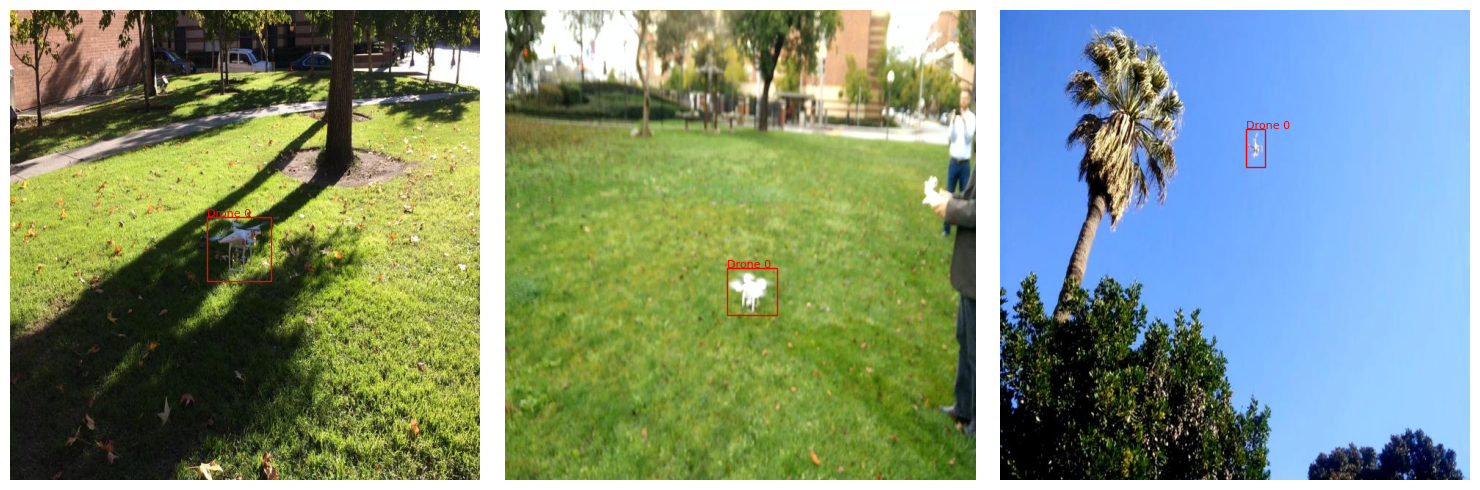


Example 1:
Image shape: torch.Size([3, 640, 640])
Number of objects: 1
Bounding boxes:
tensor([[285.5000, 280.7500, 372.5000, 368.2500]])
Labels:
tensor([0])

Example 2:
Image shape: torch.Size([3, 640, 640])
Number of objects: 1
Bounding boxes:
tensor([[270.7500, 350.7500, 338.2500, 415.2500]])
Labels:
tensor([0])

Example 3:
Image shape: torch.Size([3, 640, 640])
Number of objects: 1
Bounding boxes:
tensor([[279.2500, 161.5000, 305.7500, 213.5000]])
Labels:
tensor([0])


In [6]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision.utils import make_grid

def show_batch(dataset, num_examples=3):
    # Create figure
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))

    for i in range(num_examples):
        # Get a sample from dataset
        image, target = dataset[i]

        # Convert tensor back to numpy for visualization
        image = image.numpy().transpose((1, 2, 0))

        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

        # Plot image
        axes[i].imshow(image)

        # Plot bounding boxes
        boxes = target['boxes'].numpy()
        labels = target['labels'].numpy()

        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                               fill=False, color='red')
            axes[i].add_patch(rect)
            axes[i].text(x1, y1, f'Drone {label}',
                        color='red', fontsize=8)

        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Usage:
dataset = DroneDataset(TRAIN_DIR, train=True)
show_batch(dataset)

# Print some statistics about the first few examples
for i in range(3):
    image, target = dataset[i]
    print(f"\nExample {i+1}:")
    print(f"Image shape: {image.shape}")
    print(f"Number of objects: {len(target['boxes'])}")
    print(f"Bounding boxes:\n{target['boxes']}")
    print(f"Labels:\n{target['labels']}")

In [7]:
def get_data_loaders(train_dir, val_dir, batch_size=4):
    train_dataset = DroneDataset(train_dir, train=True)
    val_dataset = DroneDataset(val_dir, train=False)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        collate_fn=lambda x: tuple(zip(*x))
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        collate_fn=lambda x: tuple(zip(*x))
    )

    return train_loader, val_loader


In [8]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    num_batches = len(data_loader)

    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        # Should return dict with loss components
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        total_loss += losses.item()

        if (i + 1) % 10 == 0:
            print(f"Batch [{i+1}/{num_batches}], Loss: {losses.item():.4f}")

    return total_loss / num_batches

In [9]:
def get_model(num_classes=2):  # 2 classes: background and drone
    # Initialize model with updated weights parameter
    weights = torchvision.models.detection.RetinaNet_ResNet50_FPN_Weights.DEFAULT
    model = retinanet_resnet50_fpn(weights=weights)

    # Get the number of anchors from the existing head
    num_anchors = model.head.classification_head.num_anchors

    # Create new classification head
    num_classes = num_classes
    in_channels = 256  # This is the standard number of channels in FPN

    cls_logits = nn.Conv2d(in_channels, num_anchors * num_classes, kernel_size=3, stride=1, padding=1)
    torch.nn.init.normal_(cls_logits.weight, std=0.01)
    torch.nn.init.constant_(cls_logits.bias, -np.log((1 - 0.01) / 0.01))

    # Replace the classification head
    model.head.classification_head.num_classes = num_classes
    model.head.classification_head.cls_logits = cls_logits

    return model

In [10]:
@torch.no_grad()
def evaluate(model, data_loader, device):
    model.train()  # Keep in train mode since we're passing targets
    total_loss = 0
    num_batches = len(data_loader)

    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Model should return loss_dict in train mode with targets
        loss_dict = model(images, targets)

        # RetinaNet returns a dict with loss components
        assert isinstance(loss_dict, dict), f"Expected dict, got {type(loss_dict)}"
        losses = sum(loss for loss in loss_dict.values())

        total_loss += losses.item()

    return total_loss / num_batches

In [13]:
def main():
    print(f"Training data directory: {TRAIN_DIR}")
    print(f"Validation data directory: {VAL_DIR}")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    try:
        train_loader, val_loader = get_data_loaders(
            train_dir=TRAIN_DIR,
            val_dir=VAL_DIR,
            batch_size=4  # Reduced batch size
        )
        print("Data loaders created successfully")

        print("Initializing model...")
        model = get_model(num_classes=2)
        model.to(device)
        print("Model initialized successfully")

        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.AdamW(params, lr=1e-5)  # Reduced learning rate

        # Training loop
        num_epochs = 50

        best_loss = float('inf')
        model_save_path = os.path.join(MODEL_SAVE_DIR, 'best_model.pth')

        print("Starting training...")
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            train_loss = train_one_epoch(model, optimizer, train_loader, device)
            val_loss = evaluate(model, val_loader, device)

            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}")

            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(model.state_dict(), model_save_path)
                print(f"Saved new best model with validation loss: {val_loss:.4f}")

    except Exception as e:
        print(f"Error during training: {str(e)}")
        import traceback
        traceback.print_exc()

In [ ]:
if __name__ == '__main__':
    main()

Training data directory: /content/drone_dataset/train
Validation data directory: /content/drone_dataset/valid
Using device: cpu
Found 2827 images in /content/drone_dataset/train/images
Found 807 images in /content/drone_dataset/valid/images
Data loaders created successfully
Initializing model...
Model initialized successfully
Starting training...

Epoch 1/1
Batch [10/707], Loss: 1.3965


KeyboardInterrupt: 

In [12]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os

def detect_and_save(model, image_path, output_folder, device, confidence_threshold=0.5):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Load and preprocess image
    transform = get_transform(train=False)
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    transformed = transform(image=image_np)
    image_tensor = transformed['image'].unsqueeze(0).to(device)

    # Get predictions
    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)

    # Filter predictions by confidence
    boxes = predictions[0]['boxes'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()

    mask = scores >= confidence_threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]

    # Draw boxes on image
    image_draw = image.copy()
    draw = ImageDraw.Draw(image_draw)

    # Draw each detection
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box
        # Draw rectangle
        draw.rectangle([x1, y1, x2, y2], outline='red', width=3)
        # Add score text
        draw.text((x1, y1-10), f'Drone: {score:.2f}', fill='red')

    # Save the annotated image
    output_path = os.path.join(output_folder, f'detected_{os.path.basename(image_path)}')
    image_draw.save(output_path)
    print(f"Saved annotated image to {output_path}")

    return boxes, scores, labels

# Use the function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load your trained model
model = get_model(num_classes=2)
model.load_state_dict(torch.load('retina_models/best_model.pth'))
model.to(device)

# Process all images in the test folder
test_image_folder = TEST_DIR + '/images'
output_folder = 'retina_output_images'

for image_file in os.listdir(test_image_folder):
    if image_file.endswith(('.jpg', '.png', '.jpeg')):
        image_path = os.path.join(test_image_folder, image_file)
        print(f"\nProcessing {image_file}")
        boxes, scores, labels = detect_and_save(model, image_path, output_folder, device)

/tmp/ipykernel_155714/3158380998.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('retina_models/best_model.pth'))



Processing video18_1313_JPEG.rf.964a26819c2232b0ffe73bc8c4554245.jpg
Saved annotated image to retina_output_images/detected_video18_1313_JPEG.rf.964a26819c2232b0ffe73bc8c4554245.jpg

Processing video18_1099_JPEG.rf.566fb1989c2b3cfef22709d49dfc4d0e.jpg
Saved annotated image to retina_output_images/detected_video18_1099_JPEG.rf.566fb1989c2b3cfef22709d49dfc4d0e.jpg

Processing 0218_jpg.rf.a4985127caf56f70332bad0183b9df62.jpg
Saved annotated image to retina_output_images/detected_0218_jpg.rf.a4985127caf56f70332bad0183b9df62.jpg

Processing video18_2115_JPEG.rf.50f466219a80fdaa5ac70b92fdaa6054.jpg
Saved annotated image to retina_output_images/detected_video18_2115_JPEG.rf.50f466219a80fdaa5ac70b92fdaa6054.jpg

Processing video16_228_JPEG.rf.0b79bb8948b64669c119c6a0fe5889d2.jpg
Saved annotated image to retina_output_images/detected_video16_228_JPEG.rf.0b79bb8948b64669c119c6a0fe5889d2.jpg

Processing video17_833_JPEG.rf.56ef439405d4a1cc84a87a16537b1abe.jpg
Saved annotated image to retina_outp